In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_3.csv
./clustered_data.csv
./Project_3.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.csv
./.ipynb_checkpoints/clustered_data-checkpoint.csv
./models/best_bnb.pkl
./models/customer_bnb.pkl
./data/hello
./data/.ipynb_checkpoints/hello-checkpoint


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Assignment: As a customer I would like to be able to assist my sales team to target the correct customer market. Given the data emailed to you provide Insight into what you see. Then Create a ML model that would allow for a Prediction of Whether a Cog would be Purchased by the given customer.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was provided to us via csv file.

In [2]:
# import libraries
import pandas as pd
import numpy as np

In [3]:
# read data
df = pd.read_csv("Project_3.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [4]:
# drop columns i dont want (names is useless)
df_dropped = df.drop(columns=["name"])

In [5]:
# if the item is less than 0, append the abs value to new column and set old "Purchased" value to 0
# basically make a column to count returns as buys, since the user must've had to buy it in the first place

df_dummies = pd.get_dummies(df_dropped["Purchased"], dtype=int)
df_one_hot = pd.concat([df_dropped, df_dummies], axis=1)
df_one_hot = df_one_hot.rename(columns={-1: "Returned", 0: "Not Bought", 1: "Bought"})
df_one_hot["BoughtReturned"] = df_one_hot["Bought"] + np.where(df_one_hot["Returned"] == 1, 1, 0)
df_one_hot.head()

User ID  Gender  Age  EstimatedSalary  Purchased  Returned  Not Bought  \
0    10000    Male   23           122492          1         0           0   
1    10001  Female   47           142543          0         0           1   
2    10002  Female   54            70131          1         0           0   
3    10003    Male   20           108437          0         0           1   
4    10004    Male   57           100832          1         0           0   

   Bought  BoughtReturned  
0       1               1  
1       0               0  
2       1               1  
3       0               0  
4       1               1

In [6]:
import matplotlib.pyplot as plt

In [7]:
df_no_dupes = df_one_hot.drop_duplicates()
print(len(df_one_hot), len(df_no_dupes))

1001 1001


In [8]:
df_no_dupes = df_no_dupes.drop(columns="Purchased")

<BarContainer object of 1001 artists>

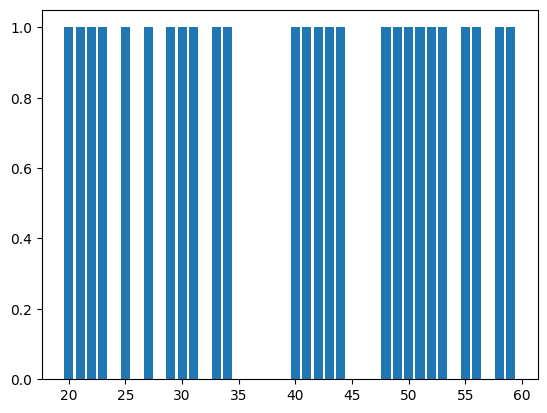

In [9]:
df_sort_age = df_no_dupes.sort_values(by="Age")
plt.bar(df_sort_age["Age"], df_sort_age["Returned"])

People did NOT return products more as they got older

In [10]:
import numpy as np

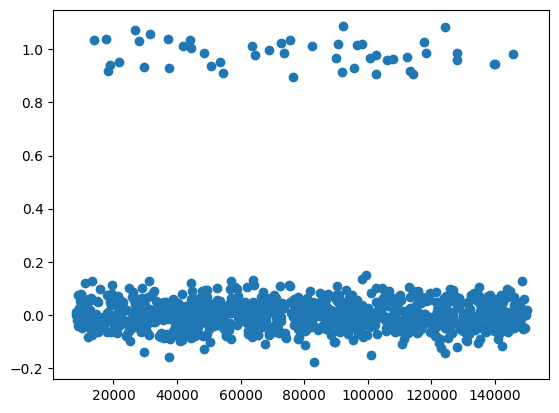

In [11]:
# plot whether people returned more things based on their salary
jitter = np.random.normal(0, 0.05, len(df_no_dupes))
price_jit = df_sort_age["Returned"] + jitter
plt.scatter(df_sort_age["EstimatedSalary"], price_jit)

In [12]:
# one hot encode gender
df_gender_dummies = pd.get_dummies(df_no_dupes["Gender"], dtype=int)
df_one_hot = pd.concat([df_no_dupes, df_gender_dummies], axis=1)
df_one_hot = df_one_hot.drop(columns=["Gender", "Female"])
df_one_hot = df_one_hot.rename(columns={"Male": "Is_male"})

In [13]:
df_one_hot.head()

User ID  Age  EstimatedSalary  Returned  Not Bought  Bought  \
0    10000   23           122492         0           0       1   
1    10001   47           142543         0           1       0   
2    10002   54            70131         0           0       1   
3    10003   20           108437         0           1       0   
4    10004   57           100832         0           0       1   

   BoughtReturned  Is_male  
0               1        1  
1               0        0  
2               1        0  
3               0        1  
4               1        1

In [14]:
# check correlation between attributes
correlation_matrix = df_one_hot.corr()
correlation_matrix = correlation_matrix["Bought"].sort_values(ascending=False)
print(correlation_matrix)

Bought             1.000000
BoughtReturned     0.906387
User ID            0.049337
EstimatedSalary    0.012867
Is_male           -0.034637
Age               -0.118995
Returned          -0.204200
Not Bought        -0.906387
Name: Bought, dtype: float64


In [15]:
from sklearn.cluster import KMeans

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [17]:
# scale my data so the kmeans clustering doesn't go crazy with large values
df_scaled = scaler.fit_transform(df_one_hot)

In [18]:
# cluster in 3 clusters (arbitrary number, just looking for patterns)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df_scaled)
print(labels)

[2 0 1 ... 1 1 2]


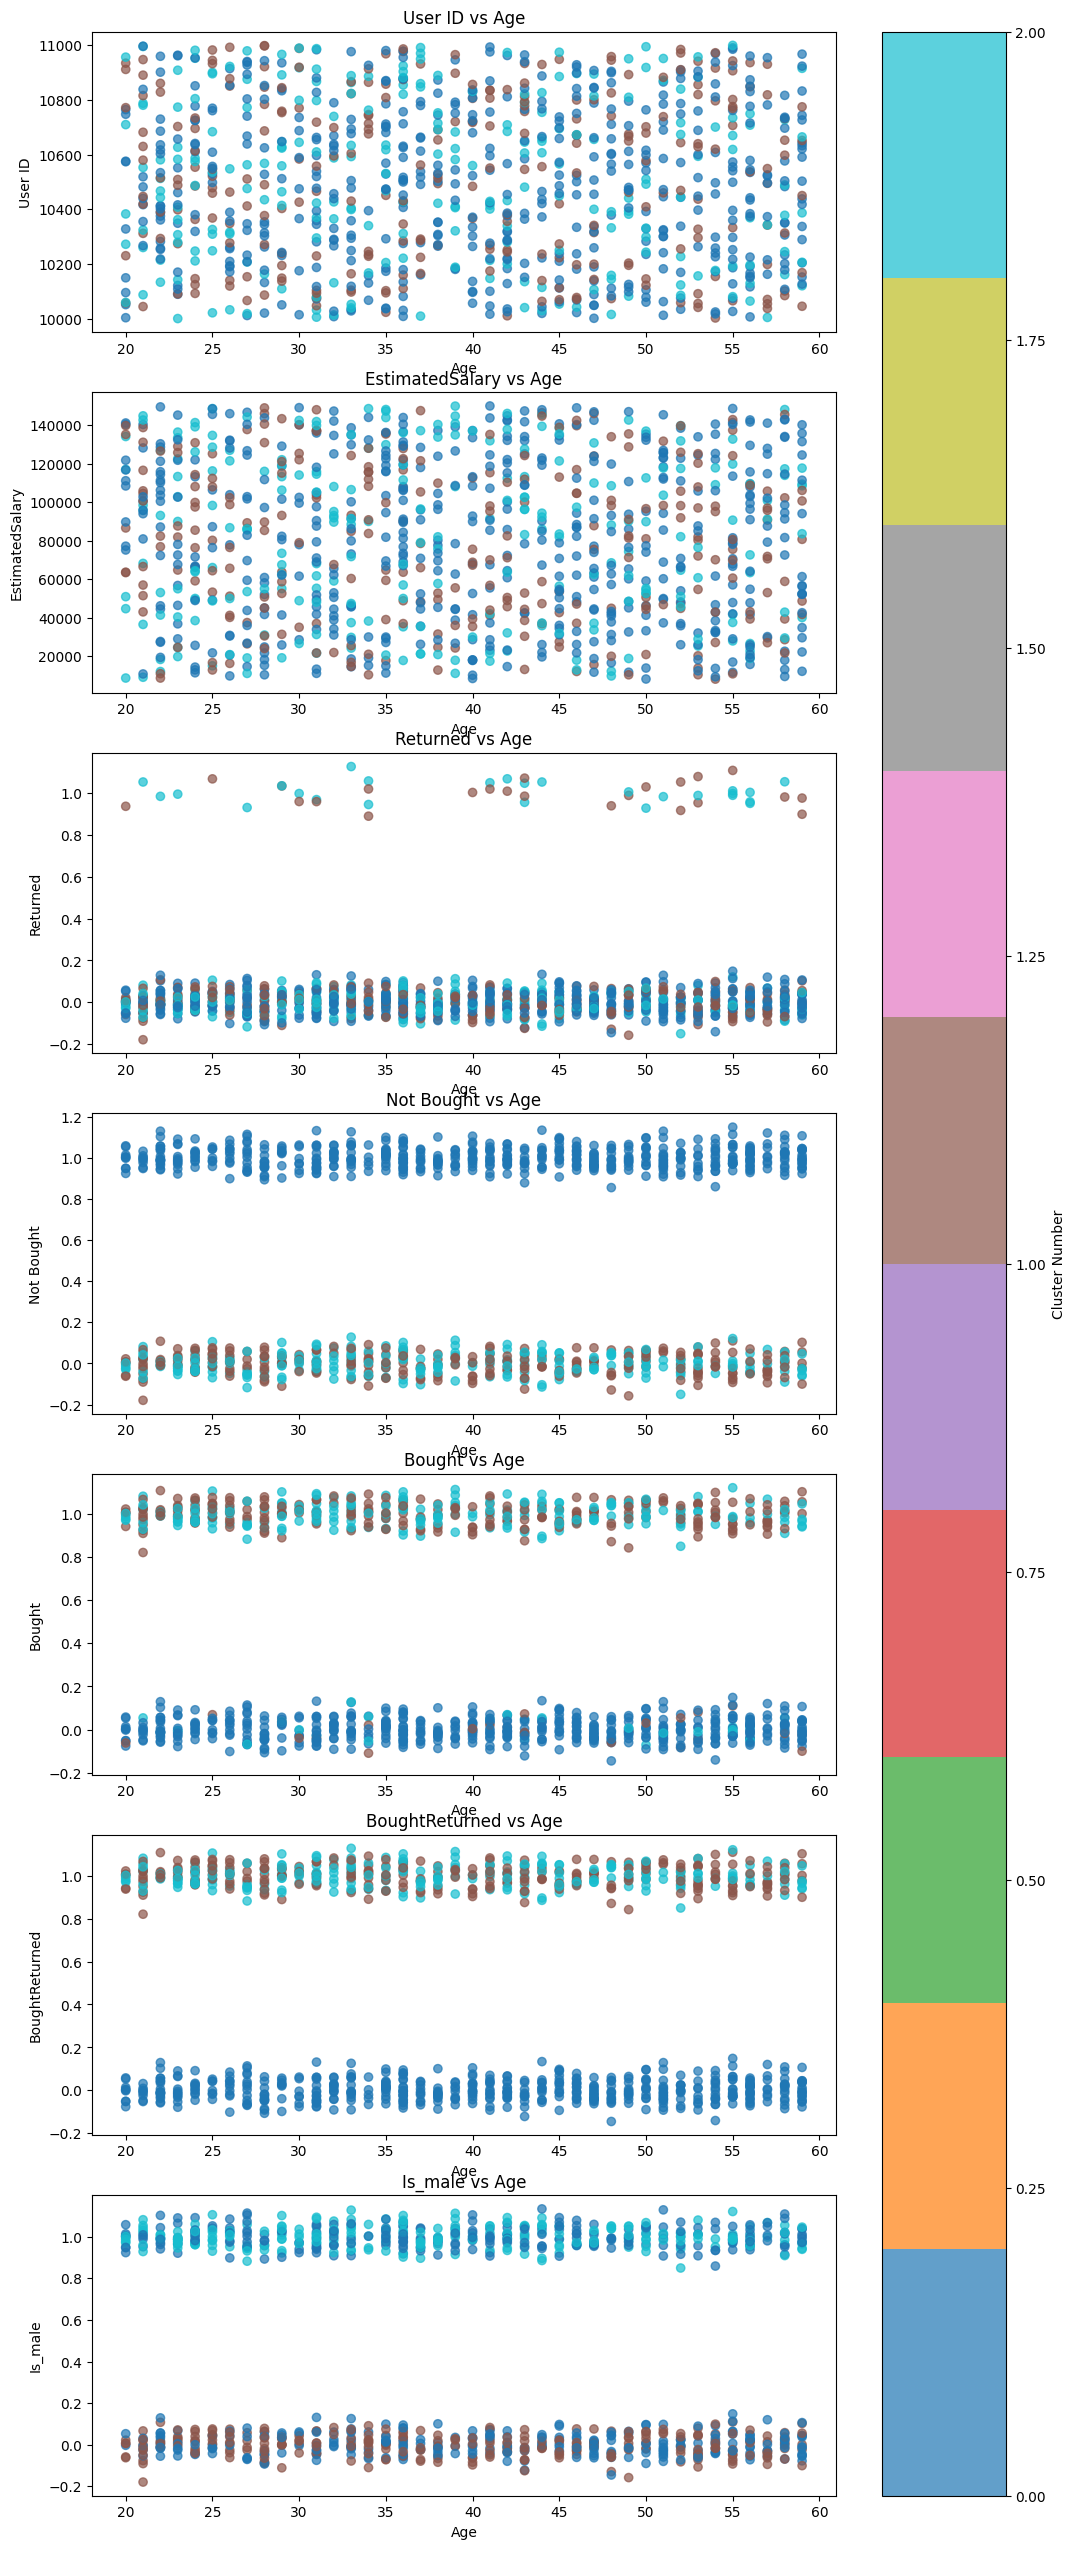

In [19]:
# plot all of the attributes in their clusters
df_one_hot["Cluster"] = labels

x_feature = "Age"
features = [col for col in df_one_hot.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_one_hot[x_feature],
        df_one_hot[feature] + jitter,
        c=df_one_hot["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

fig.colorbar(scatter, ax=axes, label="Cluster Number")
plt.show()

Everyone who returned stuff is in cluster 2.

In [20]:
# look at the means values for each attribute in each cluster
cluster_means = df_one_hot.groupby("Cluster").mean(numeric_only=True)
print(cluster_means)

              User ID        Age  EstimatedSalary  Returned  Not Bought  \
Cluster                                                                   
0        10482.442460  40.555556     79290.162698  0.000000         1.0   
1        10521.003802  39.022814     78452.425856  0.087452         0.0   
2        10514.209402  37.811966     81244.209402  0.111111         0.0   

           Bought  BoughtReturned   Is_male  
Cluster                                      
0        0.000000             0.0  0.496032  
1        0.912548             1.0  0.000000  
2        0.888889             1.0  1.000000  


I think the most unique attribute is the returned one. There aren't a lot of people who did return the cog, but I can't really see a trend right now. 

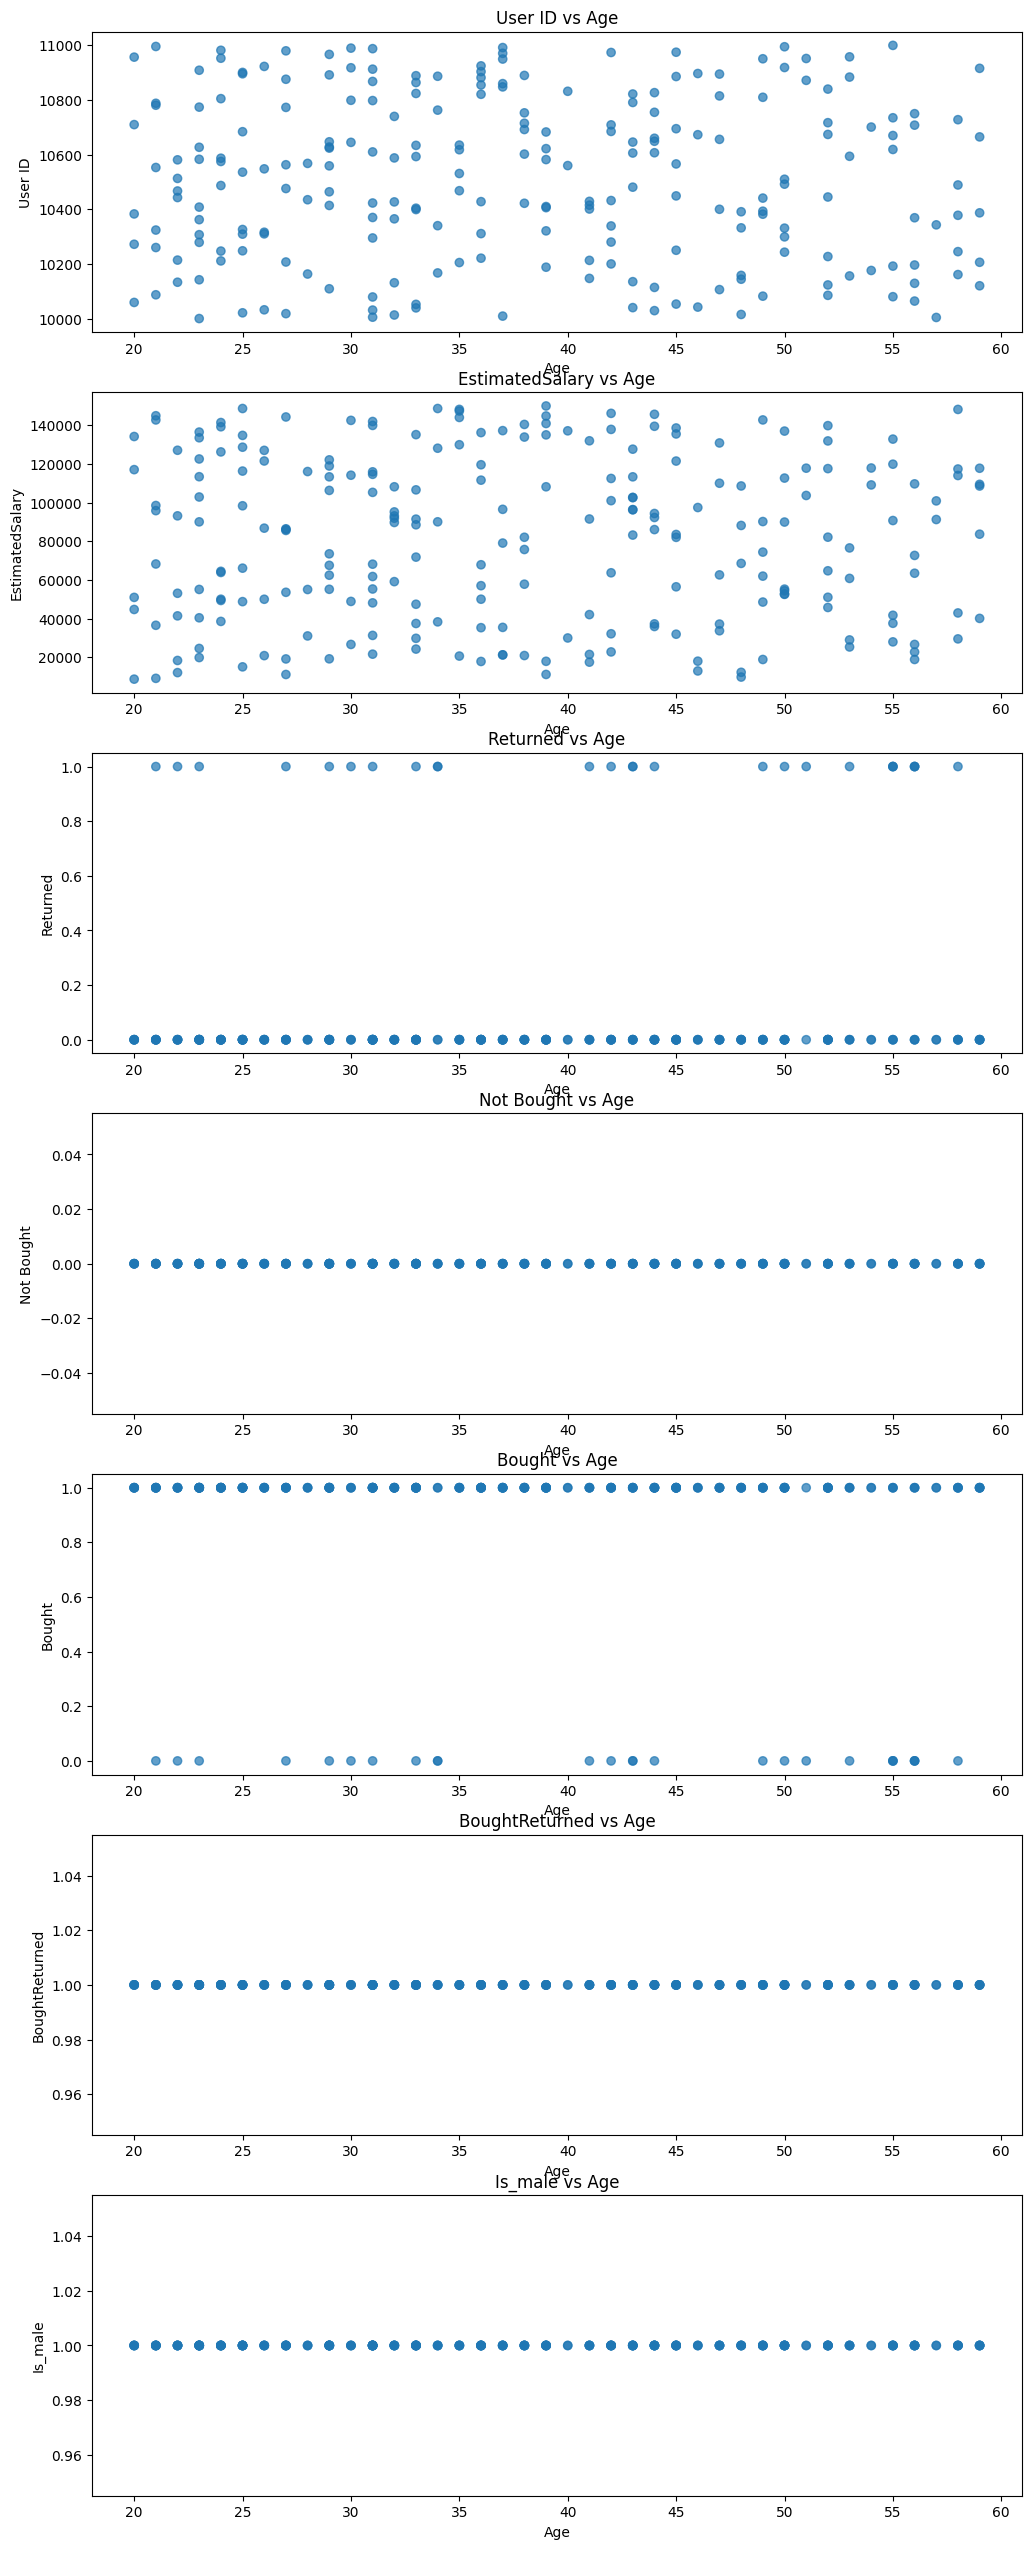

In [21]:
# plot the age values against every single attribute

df_returned = df_one_hot[df_one_hot["Cluster"] == 2]

x_feature = "Age"
features = [col for col in df_returned.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]
    
jitter_returned = np.random.normal(0, 0.01, len(df_returned))
for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_returned[x_feature],
        df_returned[feature],
        c=df_returned["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

Unfortunately I still don't know what's going on. The only thing I have been to find it the fact that both men and women returned this product around a big age, like multiples of 5 (25, 30, 35, etc.) This seems unimportant, however.

Now I'm going to cluster by user id (chronological) to see if that will reveal some trends.

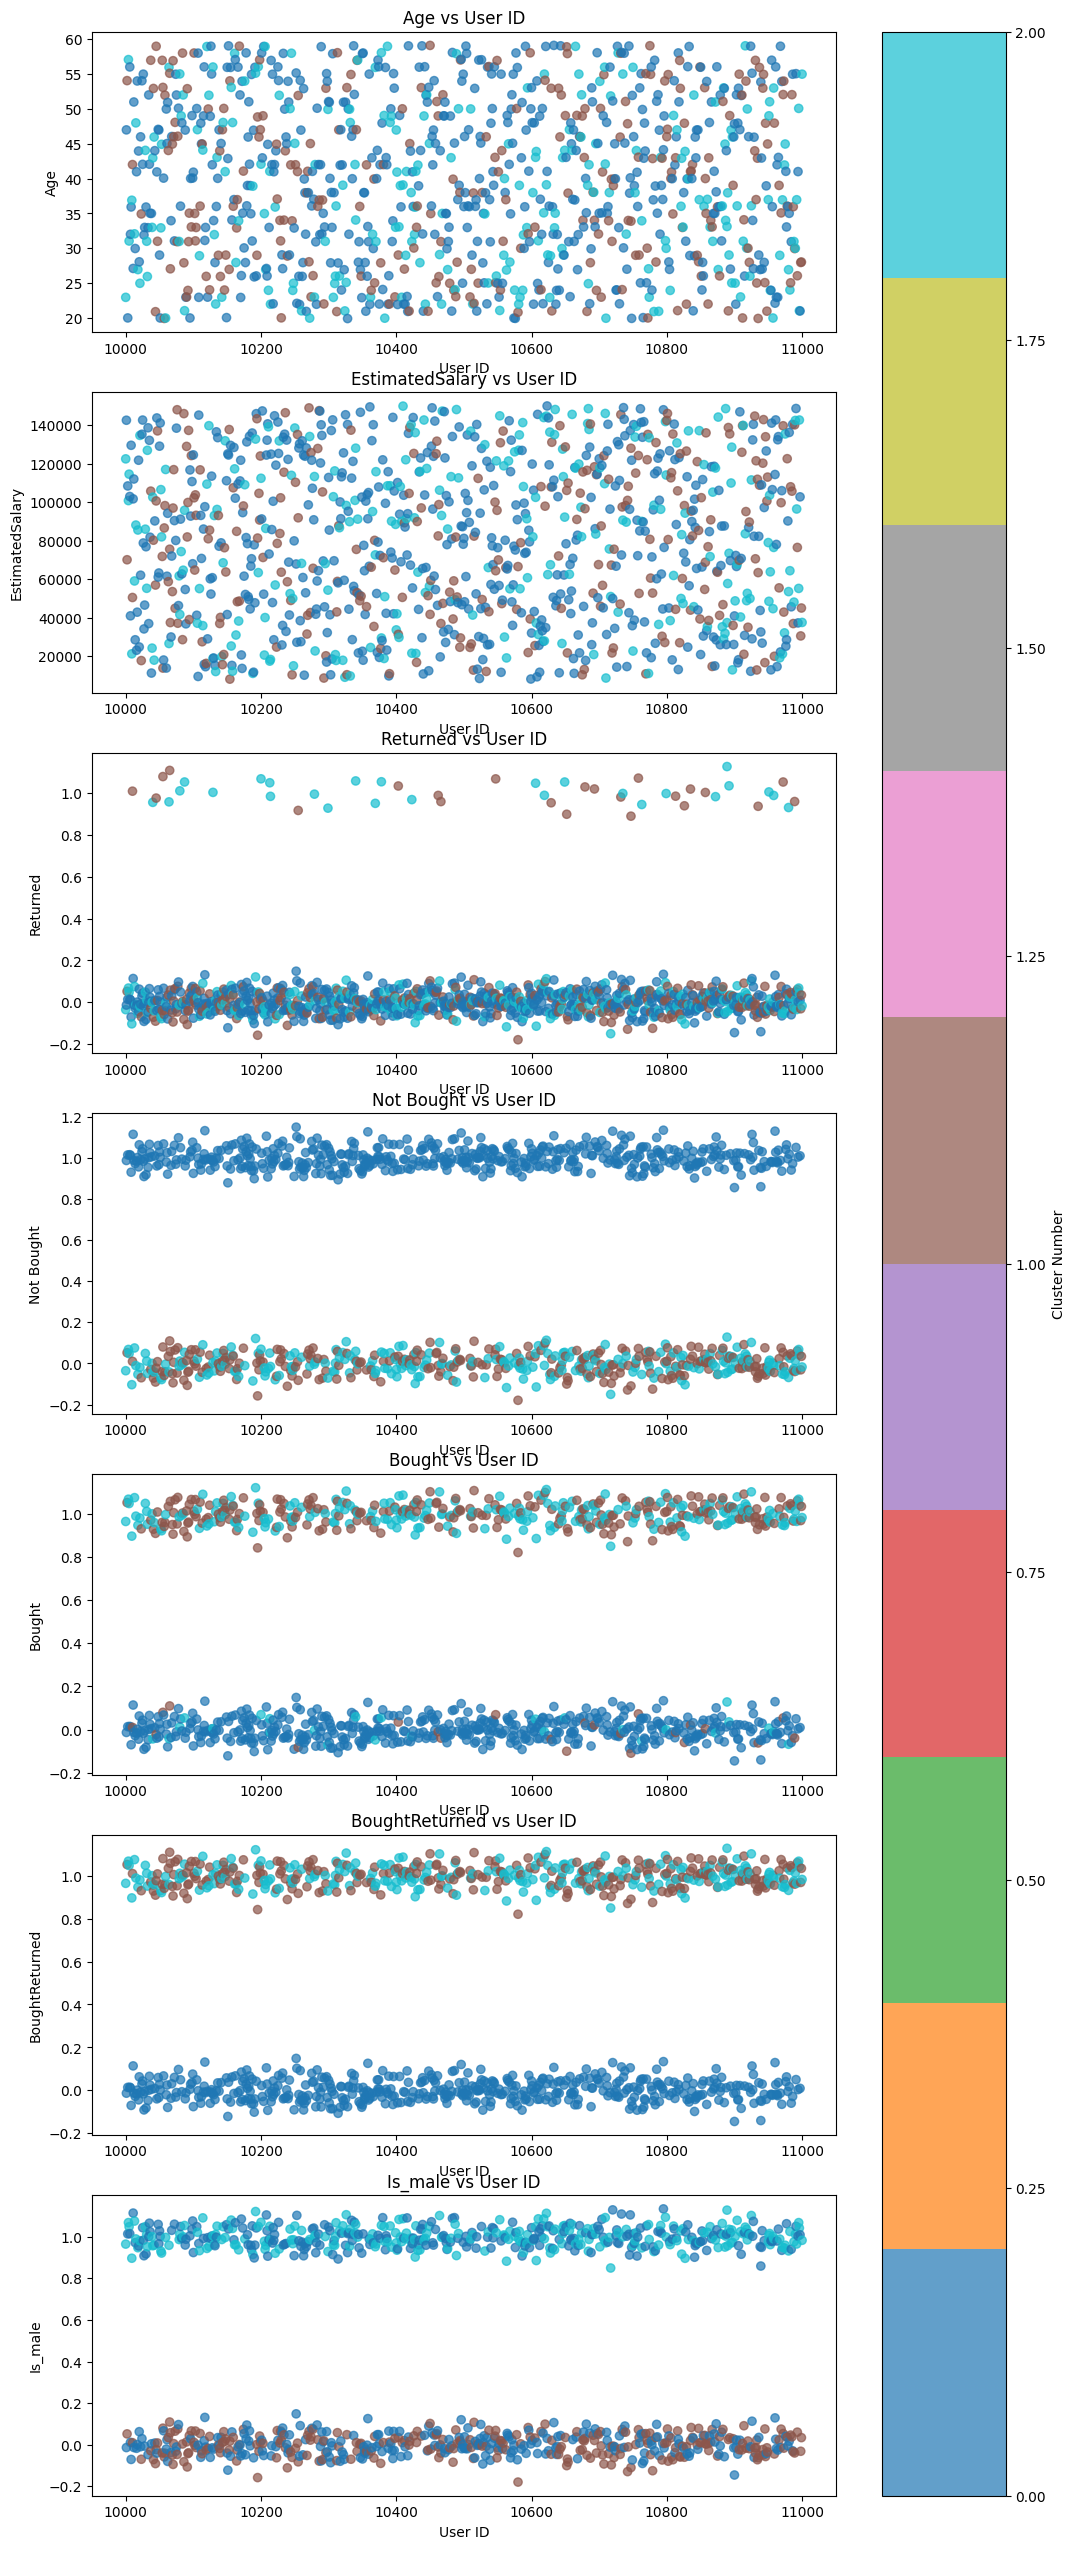

In [22]:
# plot the user id values against every single attribute

df_one_hot["Cluster"] = labels

x_feature = "User ID"
features = [col for col in df_one_hot.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_one_hot[x_feature],
        df_one_hot[feature] + jitter,
        c=df_one_hot["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

fig.colorbar(scatter, ax=axes, label="Cluster Number")
plt.show()

I'm still not sure if there is a trend here. All of the data here is mostly uniform.

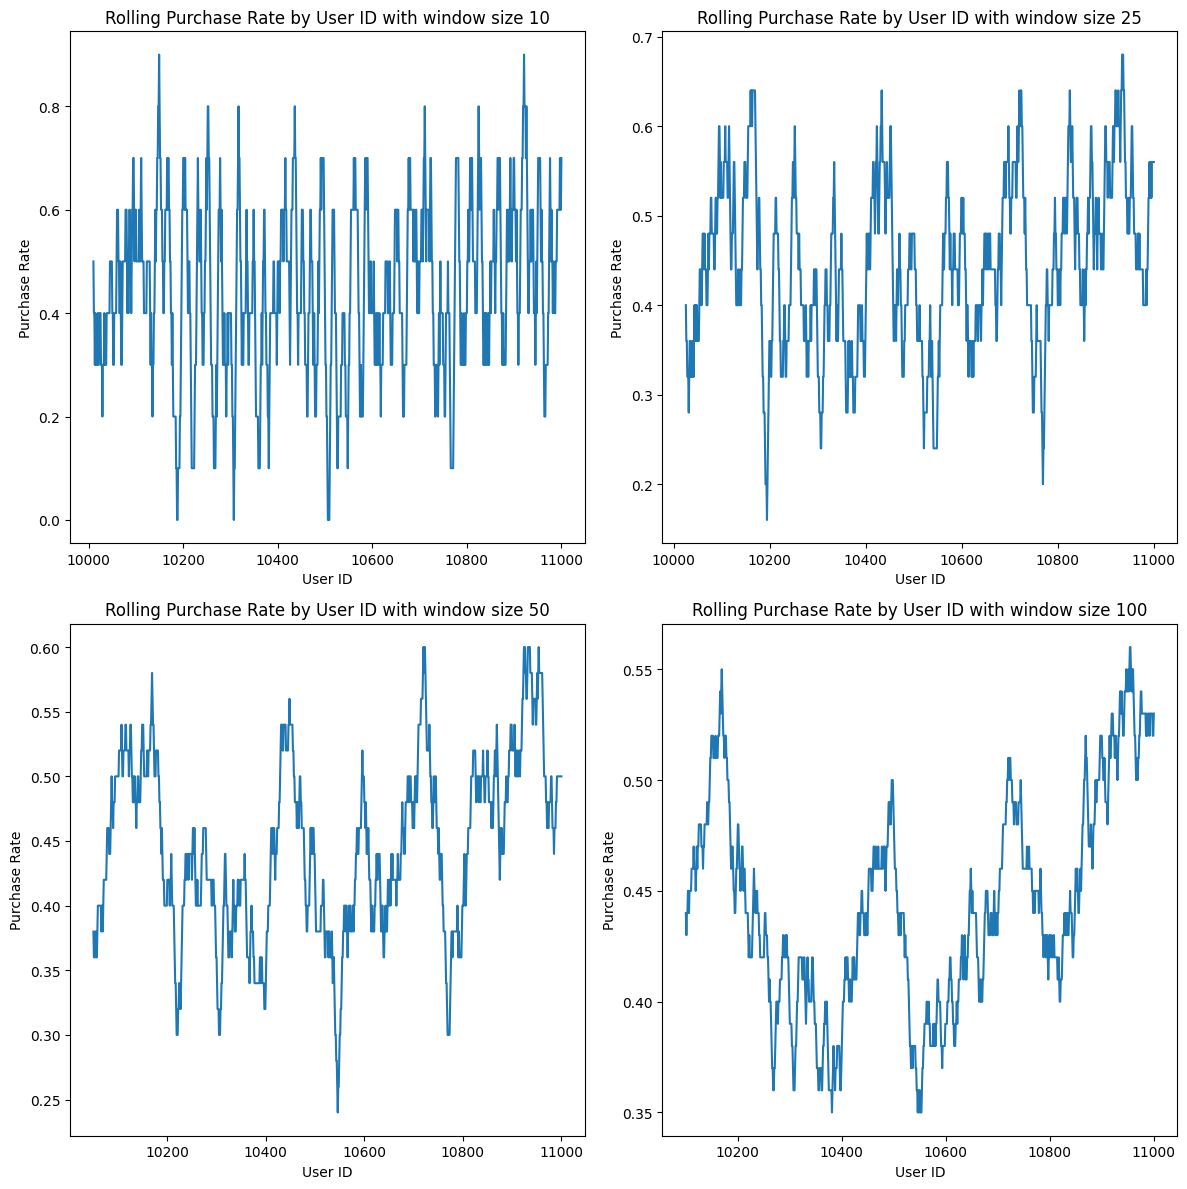

In [23]:
# compute rolling averages for the purchase rates for the user ids (chronological)
# i'm trying different window sizes to confirm whether or not there really is a trend or noise is just getting generalized too much
df_sorted = df_one_hot.sort_values("User ID")

windows = [10, 25, 50, 100]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axes = [ax1, ax2, ax3, ax4]

for i, ax in zip(windows, axes):
    rolling_purchase = df_sorted["Bought"].rolling(i).mean().shift(1)
    ax.plot(df_sorted["User ID"], rolling_purchase)
    ax.set_title(f"Rolling Purchase Rate by User ID with window size {i}")
    ax.set_xlabel("User ID")
    ax.set_ylabel("Purchase Rate")
plt.tight_layout()

This shows a much better trend. There seem to be large spikes in certain areas depending on when the user bought the item. However, as the window size decreases, the spikes become a little more sporadic and noisy, indicating there might not actually be a trend. This does NOT consider when the buyer returned the item. 

In [24]:
# compute r value to see if this trend is statistically significant
from scipy.stats import pearsonr

corr, pval = pearsonr(df_sorted["User ID"], df_sorted["Bought"])
print(f"Correlation: {corr:.4f}, p-value: {pval:.4f}")

Correlation: 0.0493, p-value: 0.1188


This means there is a very very small linear correlation between the user id and the bought rate, but the trend might also just be nonlinear.

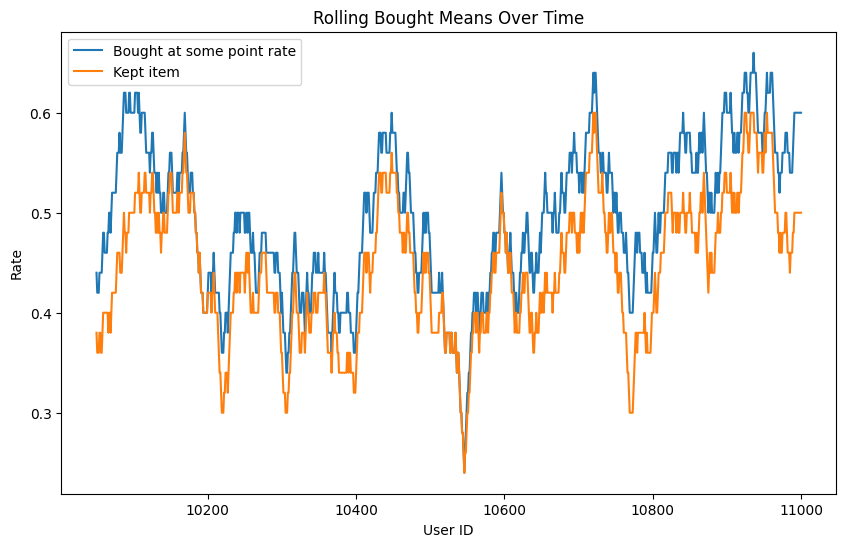

In [25]:
# compare when and how many people bought an item and if they returned it
window = 50
rolling_bought = df_sorted["BoughtReturned"].rolling(window).mean().shift(1)
rolling_kept = df_sorted["Bought"].rolling(window).mean().shift(1)

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["User ID"], rolling_bought, label="Bought at some point rate")
plt.plot(df_sorted["User ID"], rolling_kept, label="Kept item")

plt.legend()
plt.xlabel("User ID")
plt.ylabel("Rate")
plt.title("Rolling Bought Means Over Time")
plt.show()

The graphs are nearly identical, indicating no real trend in whether or not people bought and kept their items. 

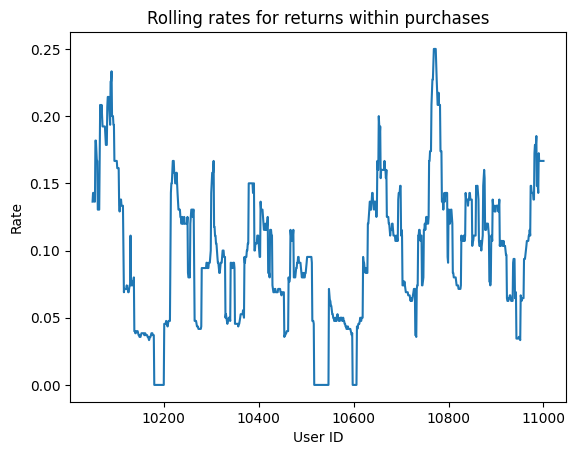

In [26]:
# compute the rolling averages for the rate of returns 
rolling_returns = df_sorted["Returned"].rolling(window).sum().shift(1)
rolling_bought_sum = df_sorted["BoughtReturned"].rolling(window).sum().shift(1)
rolling_return_rate = rolling_returns / rolling_bought_sum

plt.plot(df_sorted["User ID"], rolling_return_rate, label="Return Rate among purchases")
plt.xlabel("User ID")
plt.ylabel("Rate")
plt.title("Rolling rates for returns within purchases")
plt.show()

This graph also doesn't indicate any sort of particular trend. There are a few spikes in certain areas, but there's no overall trend to them

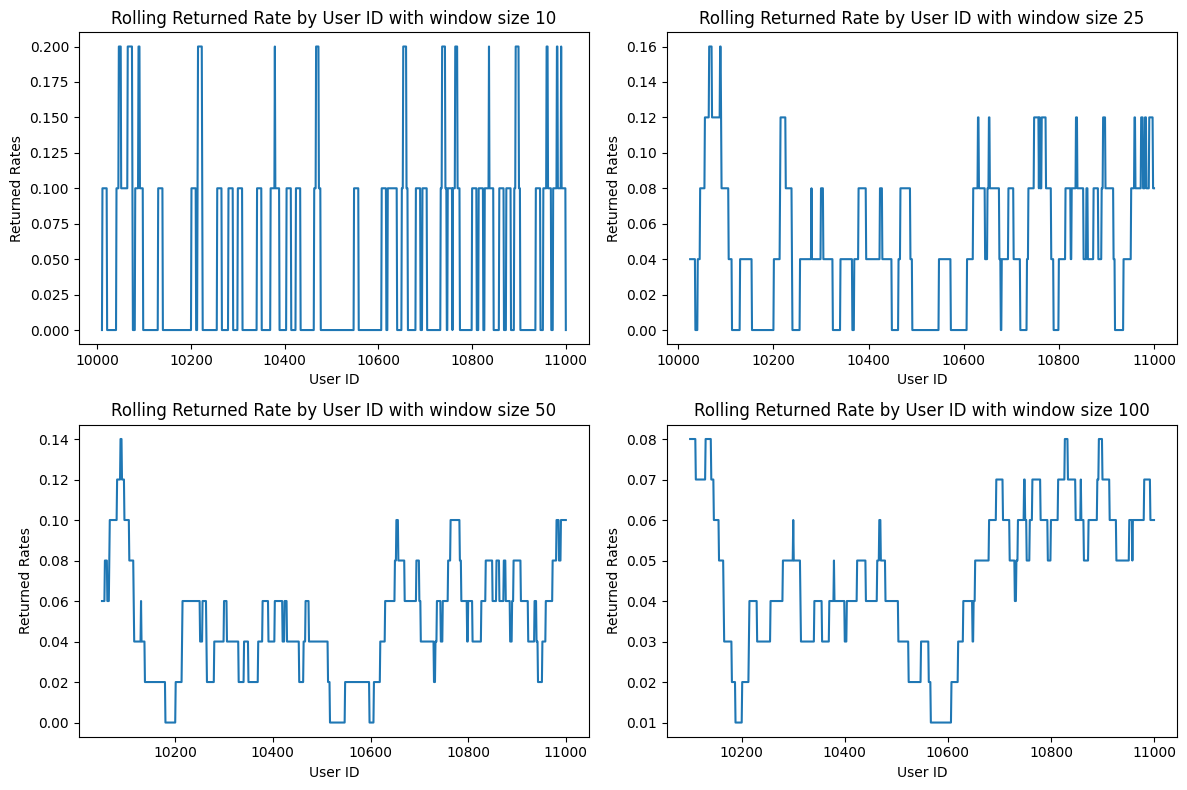

In [27]:
# trying more windows to see if i can find a good trend
df_sorted = df_one_hot.sort_values("User ID")

windows = [10, 25, 50, 100]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax1, ax2, ax3, ax4]

for i, ax in zip(windows, axes):
    rolling_returned = df_sorted["Returned"].rolling(i).mean().shift(1)
    ax.plot(df_sorted["User ID"], rolling_returned)
    ax.set_title(f"Rolling Returned Rate by User ID with window size {i}")
    ax.set_xlabel("User ID")
    ax.set_ylabel("Returned Rates")
plt.tight_layout()

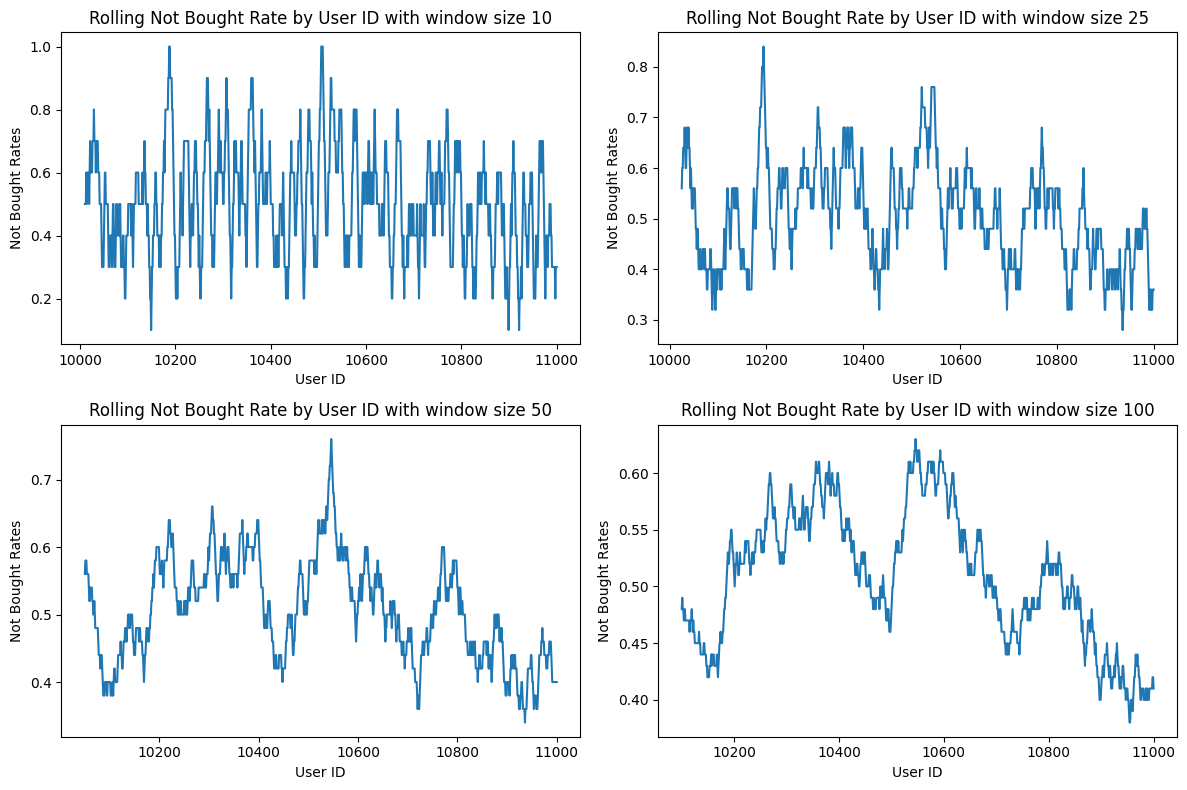

In [28]:
# compute the not bought rate just in case
df_sorted = df_one_hot.sort_values("User ID")

windows = [10, 25, 50, 100]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax1, ax2, ax3, ax4]

for i, ax in zip(windows, axes):
    rolling_no_buy = df_sorted["Not Bought"].rolling(i).mean().shift(1)
    ax.plot(df_sorted["User ID"], rolling_no_buy)
    ax.set_title(f"Rolling Not Bought Rate by User ID with window size {i}")
    ax.set_xlabel("User ID")
    ax.set_ylabel("Not Bought Rates")
plt.tight_layout()

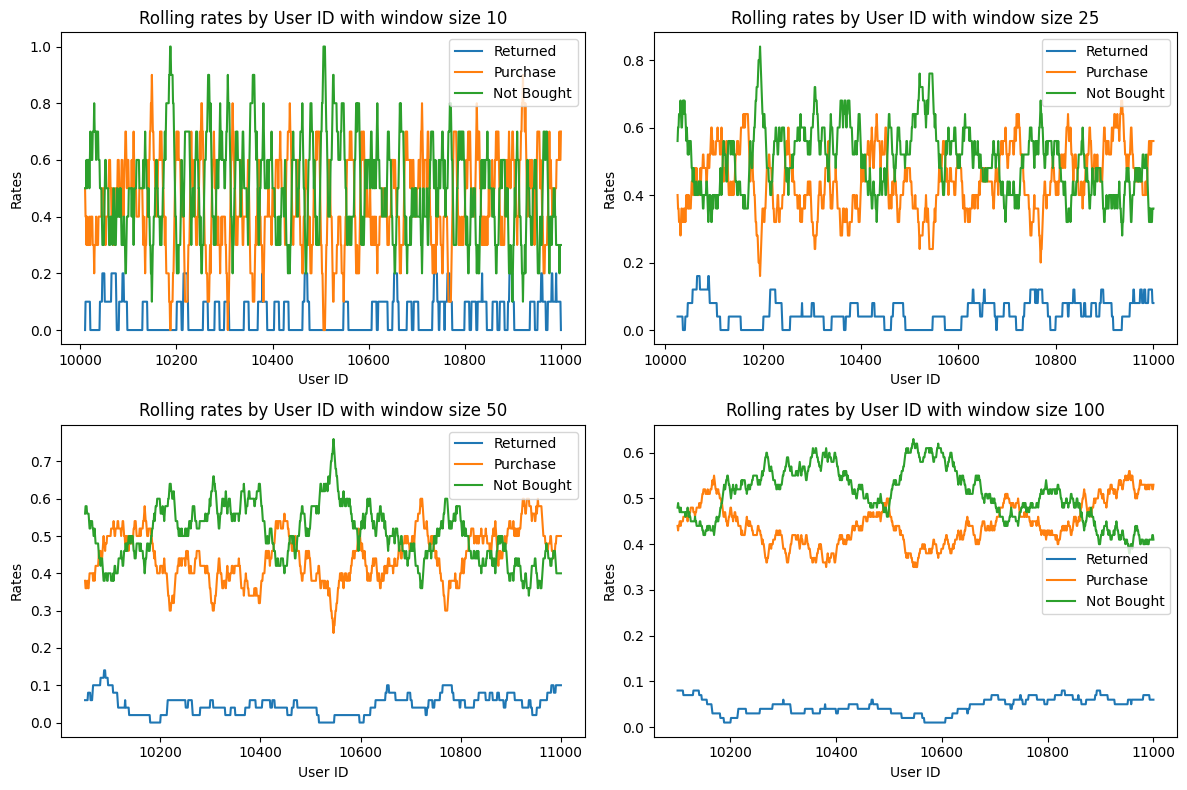

In [29]:
# compare all 3 rates against each other to see if there's any overall trend
df_sorted = df_one_hot.sort_values("User ID")

windows = [10, 25, 50, 100]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax1, ax2, ax3, ax4]

for i, ax in zip(windows, axes):
    rolling_returned = df_sorted["Returned"].rolling(i).mean().shift(1)
    rolling_purchase = df_sorted["Bought"].rolling(i).mean().shift(1)
    rolling_not_bought= df_sorted["Not Bought"].rolling(i).mean().shift(1)
    ax.plot(df_sorted["User ID"], rolling_returned, label="Returned")
    ax.plot(df_sorted["User ID"], rolling_purchase, label="Purchase")
    ax.plot(df_sorted["User ID"], rolling_not_bought, label="Not Bought")
    ax.set_title(f"Rolling rates by User ID with window size {i}")
    ax.set_xlabel("User ID")
    ax.set_ylabel("Rates")
    ax.legend()
plt.tight_layout()

## Conclusions

So far, the best thing I have found has been buying rates and the spikes at certain times. This could mean upticks in buying due to seasonal things or might just indicate a time when a new marketing campaign for the product came out. Both of these would increase sales at certain times. 

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [30]:
# save my clustered data
df_one_hot.to_csv("clustered_data.csv")

In [31]:
# read the data and format the dataframe
df_clustered = pd.read_csv("clustered_data.csv")
df_clustered.drop(df_clustered.columns[df_clustered.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df_clustered.drop(columns={"Cluster"}, inplace=True)

In [65]:
# figure out if row was during a spike
# if spike height > mean + sd or < mean - sd (had to make this a little more lax to allow for easier detection)
# statistically should be +- 2sd

df_sorted['Purchase_rate'] = df_sorted['Bought'].rolling(50, min_periods=1).mean().shift(1).fillna(df_sorted['Bought'].mean())
df_sorted['Return_rate'] = df_sorted['Returned'].rolling(50, min_periods=1).mean().shift(1).fillna(df_sorted['Bought'].mean())

mean_buy_rate = df_sorted['Purchase_rate'].mean()
std_buy_rate = df_sorted['Purchase_rate'].std()
mean_return_rate = df_sorted['Return_rate'].mean()
std_return_rate = df_sorted['Return_rate'].std()

print(df_sorted.head())

buy_spike_threshold = mean_buy_rate + std_buy_rate
return_spike_threshold = mean_return_rate + std_return_rate

df_clustered['During_buy_spike'] = (df_sorted['Purchase_rate'] > buy_spike_threshold).astype(int)
df_clustered['During_return_spike'] = (df_sorted['Return_rate'] > return_spike_threshold).astype(int)

   User ID  Age  EstimatedSalary  Returned  Not Bought  Bought  \
0    10000   23           122492         0           0       1   
1    10001   47           142543         0           1       0   
2    10002   54            70131         0           0       1   
3    10003   20           108437         0           1       0   
4    10004   57           100832         0           0       1   

   BoughtReturned  Is_male  Cluster  Purchase_rate  Return_rate  
0               1        1        2       0.447552     0.447552  
1               0        0        0       1.000000     0.000000  
2               1        0        1       0.500000     0.000000  
3               0        1        0       0.666667     0.000000  
4               1        1        2       0.500000     0.000000  


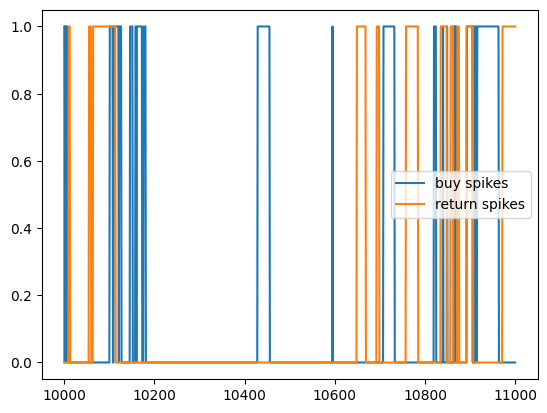

In [34]:
plt.plot(df_clustered['User ID'], df_clustered['During_buy_spike'], label="buy spikes")
plt.plot(df_clustered['User ID'], df_clustered['During_return_spike'], label="return spikes")
plt.legend()

In [35]:
df_clustered["Rolling_buy_rates"] = df_sorted["Purchase_rate"]
df_clustered["Rolling_return_rates"] = df_sorted["Return_rate"]

In [36]:
# check new correlation of attributes
correlation_matrix = df_clustered.corr()
correlation_matrix = correlation_matrix["Bought"].sort_values(ascending=False)
print(correlation_matrix)

Bought                  1.000000
BoughtReturned          0.906387
Rolling_buy_rates       0.160261
During_buy_spike        0.104467
User ID                 0.049337
Rolling_return_rates    0.043287
During_return_spike     0.020385
EstimatedSalary         0.012867
Is_male                -0.034637
Age                    -0.118995
Returned               -0.204200
Not Bought             -0.906387
Name: Bought, dtype: float64


I did a lot of data manipulation while clustering already. 

- One hot encoding: I one hot encoded the gender as well as the returned not bought and bought columns. 
- Scaling: I also scaled the salaries since they were skewing the data due to their large sizes. However, depending on whichever model I choose, I may not need to scale these values.
- Clustering: Based on the spikes my data exploration showed, I  whether or not the user id was within a spike of purchases

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [37]:
# i get some warnings that aren't that bad but can be a little annoying so i ignore them
import warnings

warnings.filterwarnings("ignore")

## LSTM Model

In [38]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate

In [39]:
# switch to gpu if we have
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# set seed and split the data based on the attributes i've selected
# make sure shuffle is false that way the chronology is preserved
np.random.seed(42)
torch.manual_seed(42)

print(df_clustered.columns)
X = df_clustered[["User ID", "Age", "During_buy_spike", "Rolling_buy_rates", "Rolling_return_rates"]].values
y = df_clustered["Bought"].values

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)

Index(['User ID', 'Age', 'EstimatedSalary', 'Returned', 'Not Bought', 'Bought',
       'BoughtReturned', 'Is_male', 'During_buy_spike', 'During_return_spike',
       'Rolling_buy_rates', 'Rolling_return_rates'],
      dtype='object')


In [42]:
# scale everything
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
# convert to tensors and create sequences
# lstms need sequences with multiple features
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return torch.stack(Xs), torch.tensor(ys).unsqueeze(-1)

seq_length = 50

trainX, trainY = create_sequences(X_train_tensor, y_train_tensor, seq_length)
testX, testY = create_sequences(X_test_tensor, y_test_tensor, seq_length)

In [44]:
# define my lstm model
# https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.25):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        # added dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        # added sigmoid output to make sure output is 0 or 1 for not bought or bought
        self.sigmoid_output = nn.Sigmoid()

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.sigmoid_output(out)
        return out, hn, cn

In [45]:
# set seed and define loss func and optimizer (BCE loss and Adam optimization)
torch.manual_seed(42)
model = LSTMModel(input_dim=trainX.shape[2], hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
print(model)

LSTMModel(
  (lstm): LSTM(5, 100, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid_output): Sigmoid()
)


In [47]:
# training!
# train for 100 epochs

num_epochs = 100

for epoch in range(num_epochs):
    # set seed and train
    torch.manual_seed(42 + epoch)
    model.train()
    # reset gradients and hiddent state (short term) and cell state (long term)
    optimizer.zero_grad()
    h0, c0 = None, None

    # get updated outputs
    outputs, h0, c0 = model(trainX, h0, c0)

    # calc error
    loss = criterion(outputs, trainY)
    # back propagate
    loss.backward()
    # use graidents to find best params
    optimizer.step()

    # reset the graidents and print loss
    with torch.no_grad():
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE Loss: {np.sqrt(loss.item()):.4f}')

Epoch [10/100], Loss: 0.6792, RMSE Loss: 0.8241
Epoch [20/100], Loss: 0.6726, RMSE Loss: 0.8201
Epoch [30/100], Loss: 0.6435, RMSE Loss: 0.8022
Epoch [40/100], Loss: 0.6446, RMSE Loss: 0.8029
Epoch [50/100], Loss: 0.6170, RMSE Loss: 0.7855
Epoch [60/100], Loss: 0.5912, RMSE Loss: 0.7689
Epoch [70/100], Loss: 0.5523, RMSE Loss: 0.7432
Epoch [80/100], Loss: 0.5075, RMSE Loss: 0.7124
Epoch [90/100], Loss: 0.4510, RMSE Loss: 0.6716
Epoch [100/100], Loss: 0.3683, RMSE Loss: 0.6069


In [48]:
# eval the function
model.eval()
predicted, _, _ = model(testX)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

# find accuracy score
preds = predicted.round()

accuracy = accuracy_score(testY.detach().numpy(), preds.detach().numpy())
print("Accuracy:", accuracy)

Accuracy: 0.5562913907284768


A bit better than guessing.

In [50]:
# using cross validation accuracy measures
# https://medium.com/biased-algorithms/cross-validation-in-pytorch-2f9f9fa9ab16
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from torch.utils.data import TensorDataset, Subset, DataLoader

# split the data by time series instead of kfold
tss = TimeSeriesSplit(n_splits=10)

# define tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)

fold_scores = []

# go through the tss splits from the data
for fold, (train_idx, val_idx) in enumerate(tss.split(dataset)):
    # Subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Dataloaders
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    # redefine model
    torch.manual_seed(42)
    model = LSTMModel(input_dim=X_tensor.shape[1], hidden_dim=100, layer_dim=1, output_dim=1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # eval the model for each split
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs, _, _ = model(batch_X.unsqueeze(1))
            preds = torch.round(outputs)
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    fold_scores.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

print(f"CV Accuracy: {np.mean(fold_scores)}")

Fold 1 Accuracy: 0.5055
Fold 2 Accuracy: 0.5934
Fold 3 Accuracy: 0.6264
Fold 4 Accuracy: 0.5275
Fold 5 Accuracy: 0.6593
Fold 6 Accuracy: 0.5495
Fold 7 Accuracy: 0.5055
Fold 8 Accuracy: 0.5934
Fold 9 Accuracy: 0.4945
Fold 10 Accuracy: 0.4505
CV Accuracy: 0.5505494505494506


About the same, no overfitting!!

In [51]:
# define utility function for getting the stat scores of a model
def return_stats(model):
    global X_train, X_test, y_train, y_test
    
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, np.round(y_test_pred))
    print("Accuracy:", accuracy)

    print(classification_report(y_test, y_test_pred))

    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print("CV Accuracy", scores.mean())

## KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier

# knn model
knn = KNeighborsClassifier()
return_stats(knn)

Accuracy: 0.4975124378109453
              precision    recall  f1-score   support

           0       0.48      0.72      0.57        95
           1       0.54      0.30      0.39       106

    accuracy                           0.50       201
   macro avg       0.51      0.51      0.48       201
weighted avg       0.51      0.50      0.48       201

CV Accuracy 0.5305555555555556


Not too bad. Still worse than guessing. 

CV accuracy is pretty good, but still not much higher than guessing.

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# random forest model
rf = RandomForestClassifier(random_state=42)
return_stats(rf)

Accuracy: 0.4975124378109453
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        95
           1       0.53      0.39      0.45       106

    accuracy                           0.50       201
   macro avg       0.50      0.50      0.49       201
weighted avg       0.51      0.50      0.49       201

CV Accuracy 0.5277777777777778


Similar scores just a little lower than the KNN. 

## Graident Boosting

In [54]:
# gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
return_stats(gb)

Accuracy: 0.5174129353233831
              precision    recall  f1-score   support

           0       0.49      0.74      0.59        95
           1       0.58      0.32      0.41       106

    accuracy                           0.52       201
   macro avg       0.53      0.53      0.50       201
weighted avg       0.54      0.52      0.50       201

CV Accuracy 0.525


Worse than both the random forest and the KNN.

## XG Boost

In [55]:
from xgboost import XGBClassifier

# xg boost classifier
xg = XGBClassifier(objective="binary:logistic", eval_metric="logloss")
return_stats(xg)

Accuracy: 0.48258706467661694
              precision    recall  f1-score   support

           0       0.41      0.21      0.28        95
           1       0.51      0.73      0.60       106

    accuracy                           0.48       201
   macro avg       0.46      0.47      0.44       201
weighted avg       0.46      0.48      0.45       201

CV Accuracy 0.5374999999999999


Worst accuracy score but best CV score so far. Not sure why the gap is this way. If the test accuracy was much higher it might've been overfitting, but I'm not sure.

## Gaussian Naive Bayes

In [56]:
from sklearn.naive_bayes import GaussianNB

# gaussian naive bayes model
gnb = GaussianNB()
return_stats(gnb)

Accuracy: 0.5870646766169154
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        95
           1       0.61      0.61      0.61       106

    accuracy                           0.59       201
   macro avg       0.59      0.59      0.59       201
weighted avg       0.59      0.59      0.59       201

CV Accuracy 0.5638888888888888


Second best accuracy out of all the models for test and cv!

## Bernoulli Naive Bayes

In [57]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import BernoulliNB

# bernoulli naive bayes model
bnb = BernoulliNB()
return_stats(bnb)

Accuracy: 0.6069651741293532
              precision    recall  f1-score   support

           0       0.62      0.43      0.51        95
           1       0.60      0.76      0.67       106

    accuracy                           0.61       201
   macro avg       0.61      0.60      0.59       201
weighted avg       0.61      0.61      0.60       201

CV Accuracy 0.5875


Best accuracy for both test accuracy and cv accuracy!

I think this model is really good because it is pretty much written for this purpose. It handles discrete data with the expectation of binary variables. Most of my features are binary, so it works out!

In [58]:
# train model for customer use
# i wrote this prior to clarifying instructions just in case i misunderstood

Xc = df_clustered[["User ID", "Age", "EstimatedSalary", "Is_male"]].values
yc = df_clustered["Bought"].values

X_trainc, X_testc, y_trainc, y_testc = train_test_split(Xc, 
                                                    yc, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)

customer_scaler = StandardScaler()

customer_scaler.fit(X_trainc)
X_trainc = customer_scaler.transform(X_trainc)
X_testc = customer_scaler.transform(X_testc)

## Cusomter BNB

In [59]:
# define and train the customer BNB model
customer_bnb = BernoulliNB()
customer_bnb.fit(X_trainc, y_trainc)

y_test_predc = customer_bnb.predict(X_testc)
accuracy = accuracy_score(y_test, np.round(y_test_predc))
print("Accuracy:", accuracy)

print(classification_report(y_testc, y_test_predc))

cv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(customer_bnb, X_trainc, y_trainc, scoring='accuracy', cv=cv, n_jobs=-1)
print("CV Accuracy", scores.mean())

Accuracy: 0.4975124378109453
              precision    recall  f1-score   support

           0       0.48      0.88      0.62        95
           1       0.59      0.15      0.24       106

    accuracy                           0.50       201
   macro avg       0.54      0.52      0.43       201
weighted avg       0.54      0.50      0.42       201

CV Accuracy 0.5305555555555556


Not bad accuracy for something that doesn't use any of the data trends.

## Conclusions

Based on all of these attributes, I will be using the Bernoulli Naive-Bayes model. It has both the highest CV and test accuracy scores.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [60]:
from sklearn.model_selection import RandomizedSearchCV

# random search to find best params for bnb
bnb_params = {'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
              'binarize': [None, 0.2, 0.4, 0.6, 0.8, 1.0], 
              'fit_prior': [True, False],
             }

rand_bnb = RandomizedSearchCV(bnb, 
                             param_distributions=bnb_params)

rand_bnb.fit(X_train, y_train)

print("Best Params for random for bnb:", rand_bnb.best_params_)
print("Best CV Score for random for bnb:", rand_bnb.best_score_)
best_bnb = rand_bnb.best_estimator_

Best Params for random for bnb: {'fit_prior': True, 'binarize': None, 'alpha': 0.2}
Best CV Score for random for bnb: 0.5725


This lowered my CV accuracy slightly (59% -> 57%)

In [61]:
import joblib

# dump models
joblib.dump(bnb, './models/best_bnb.pkl')
joblib.dump(customer_bnb, './models/customer_bnb.pkl')

['./models/customer_bnb.pkl']

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


First, I examined the data to look for trends. The data seemed pretty randomized, and even with hints that the data was clustered, I still couldn't find any specific patterns while using K means clustering. Eventually, I used rollings means (using a sliding window to calculate means) and found some spikes in buying rates at specific times. While these were very noisy and might have just been random, calculating which points were within those spikes seemed to have a decent correlation. 

Next, I tries a bunch of models to find the best one for this purpose. I first tried LSTM (long short term memory), which is good for looking at clusters. However, this didn't give me much more than flipping a coin and guessing. The same thing happened with many of my other models until I tried using Naive Bayes ones. These provided much higher scores than I was getting with any other model, especially the Bernoulli Naive Bayes model, which gave a test accuracy of 61% and a cross validation accuracy of 59%. 

Finally, with this model, I tried to fine tune it. However when I did, the cross validation accuracy just went down. So I saved my previous model to use instead.

However, there is the issue that this data is not available to people who are not part of the company. The project description says "as a customer I would like to be able to assist my sales team to target the correct customer market," which implies there might be a typo. If not, my model will be very bad. 

In terms of data leakage, I think the model is okay. I'm using time aware splitting for my cross validation as well as not shuffling my test train split to preserve the chronology of user ids. I'm also calculating rolling averages using only historical data. However, just in case, I'm using a pretrained BernoulliNB model if the user does not have access to historical data.

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [62]:
# import libraries
import pandas as pd
import numpy as np
import joblib

def infrence(admin:str, user_id:int, age:int, salary:float=None, gender:str=None):

    # one hot encode input variables
    admin = 0 if admin == "N" else 1
    gender = 1 if gender == "Male" else 0

    # if allowed access to historical data
    if admin:
        # read the data
        historical_data = pd.read_csv("Project_3.csv")

        # make a subset of the data to only get trends up until the user
        subset = historical_data[historical_data['User ID'].astype(int) < user_id].copy()
        # calculate buying and returning rates
        buy_rates = subset['Purchased'].replace(-1, 0).shift(1).rolling(50, min_periods=1).mean()
        subset['Returned'] = np.where(subset['Purchased'] == -1, 1, 0)
        return_rates = subset['Returned'].shift(1).rolling(50, min_periods=1).mean()

        # calculate spike thresholds
        mean_buy_rate = buy_rates.mean()
        std_buy_rate = buy_rates.std()
        buy_spike_threshold = mean_buy_rate + std_buy_rate

        # take the most recent rates for everything to use for prediction
        during_buy_spike = (buy_rates.iloc[-1] > buy_spike_threshold).astype(int)
        rolling_buy_rates = buy_rates.iloc[-1]
        rolling_return_rates = return_rates.iloc[-1]

        # load the model
        model = joblib.load("./models/best_bnb.pkl")
        # predict!
        pred = model.predict(np.array([user_id, age, during_buy_spike, rolling_buy_rates, rolling_return_rates]).reshape(1, -1))
    else:
        # load the model
        model = joblib.load("./models/customer_bnb.pkl")
        # predict!
        pred = model.predict(np.array([user_id, age, salary, gender]).reshape(1, -1))
        
    return pred[0]

In [63]:
# allowed access to historical data, user id: 10997, age 21
print("not bought" if infrence("Y", 10997, 21) == 0 else "bought")

not bought


Row 998 of the dataset: item was not bought

In [64]:
# not allowed access to historical data, user id: 10776, age 55, salary 60614, gender female
print("not bought" if infrence("N", 10776, 55, 60614, "Female") == 0 else "bought")

not bought


Row 777 of the dataset: item was bought